# Fashion MNIST
- Vishal Maurya MDS202354
- Ashish Bisht MDS202313

## Libraries used

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
import warnings
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

## Loading Dataset

In [2]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Rescaling

In [3]:
train_images = train_images/255
test_images = test_images/255

## Visualising a image

In [4]:
train_images.shape

(60000, 28, 28)

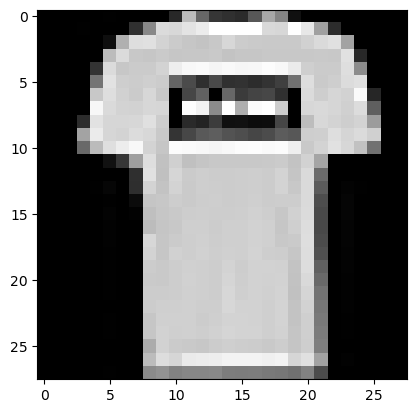

In [5]:
plt.imshow(train_images[1], cmap = 'gray')

## Clustering

In [6]:
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

In [7]:
s = time.time()

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, n_init = 4)
kmeans.fit(train_images_flattened)

print(time.time() - s)

52.183234453201294


In [8]:
train_labels_clustered = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

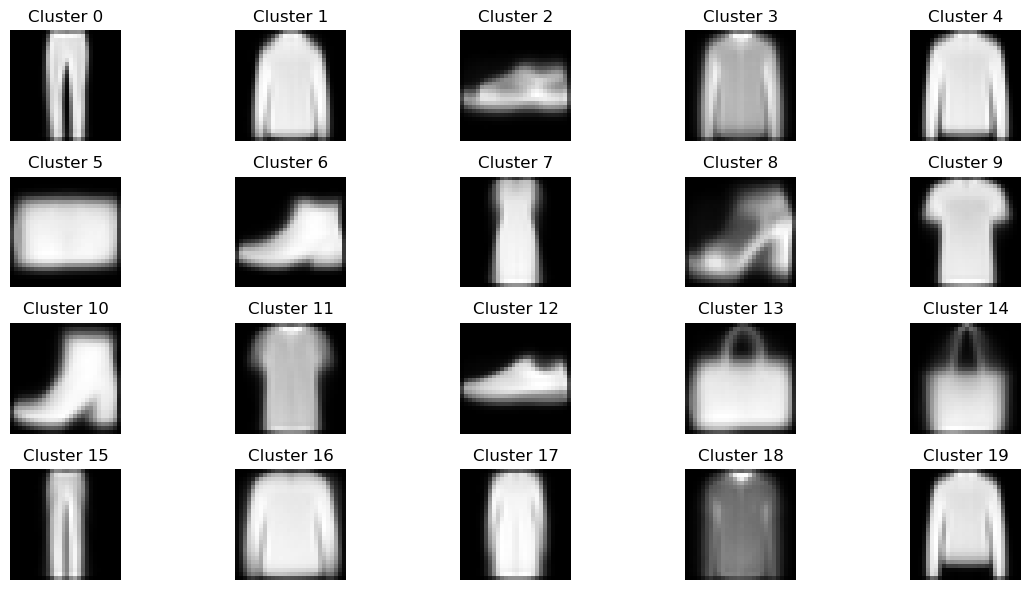

In [9]:
fig, axs = plt.subplots(4, 5, figsize=(12, 6))
for i in range(20):
    ax = axs[i // 5, i % 5]
    ax.imshow(cluster_centers[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Cluster {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Finding representative images
- Finding nearest image corresponding to each centroid

In [10]:
nearest_images = []
nearest_labels = []

for cluster_no in range(n_clusters):
    cluster_indices = np.where(train_labels_clustered == cluster_no)[0]
    cluster_images = train_images_flattened[cluster_indices]
    cluster_labels = train_labels[cluster_indices]
    
    distances = np.linalg.norm(cluster_images - cluster_centers[cluster_no], axis=1)
    nearest_index = np.argmin(distances)
    nearest_images.append(cluster_images[nearest_index])
    nearest_labels.append(cluster_labels[nearest_index])

nearest_images = np.array(nearest_images)
nearest_labels = np.array(nearest_labels)

In [11]:
nearest_labels

array([1, 4, 7, 2, 2, 8, 9, 3, 9, 0, 9, 0, 7, 8, 8, 1, 2, 3, 6, 2],
      dtype=uint8)

## Propagation 
- Finding a fraction of nearest images within a cluster and labelling them with the nearest label to the centrod of the cluster

In [12]:
nearest_images_within_cluster = []
nearest_labels_within_cluster = []

for cluster_no in range(n_clusters):
    cluster_indices = np.where(train_labels_clustered == cluster_no)[0]
    cluster_images = train_images_flattened[cluster_indices]
    cluster_labels = train_labels[cluster_indices]
    
    num_nearest = max(1, len(cluster_images) // 5)
    
#     distances = np.linalg.norm(cluster_images - cluster_centers[cluster_no], axis=1)
    distances = np.linalg.norm(cluster_images - nearest_images[cluster_no], axis=1)
    nearest_indices = np.argsort(distances)[:num_nearest]
    
    nearest_images_within_cluster.extend(cluster_images[nearest_indices])
    nearest_labels_within_cluster.extend([nearest_labels[cluster_no]]*num_nearest)

nearest_images_within_cluster = np.array(nearest_images_within_cluster)
nearest_labels_within_cluster = np.array(nearest_labels_within_cluster)

In [13]:
nearest_images_within_cluster.shape, nearest_labels_within_cluster.shape

((11993, 784), (11993,))

In [14]:
X = nearest_images_within_cluster
y = nearest_labels_within_cluster

## Supervised model for classification

In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(nearest_images_within_cluster, nearest_labels_within_cluster)
y_pred = mlp.predict(test_images_flattened)

In [18]:
print(accuracy_score(test_labels,y_pred))

0.6091


## Semi-supervised model with Kmeans and MLPClassifier
- Just added all the steps above in as a function `model`
- Hyperparameter `threshold` is fraction of images we need to add in data for supervised learning with `MLPClassifier` within a cluster.

In [19]:
def model(train_images, train_labels, n_clusters, threshold):
    train_images_flattened = train_images.reshape(train_images.shape[0], -1)
    test_images_flattened = test_images.reshape(test_images.shape[0], -1)

    kmeans = KMeans(n_clusters=n_clusters, n_init = 5)
    kmeans.fit(train_images_flattened)
    train_labels_clustered = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    nearest_images = []
    nearest_labels = []

    for cluster_no in range(n_clusters):
        cluster_indices = np.where(train_labels_clustered == cluster_no)[0]
        cluster_images = train_images_flattened[cluster_indices]
        cluster_labels = train_labels[cluster_indices]

        distances = np.linalg.norm(cluster_images - cluster_centers[cluster_no], axis=1)
        nearest_index = np.argmin(distances)
        nearest_images.append(cluster_images[nearest_index])
        nearest_labels.append(cluster_labels[nearest_index])

    nearest_images = np.array(nearest_images)
    nearest_labels = np.array(nearest_labels)
    
    nearest_images_within_cluster = []
    nearest_labels_within_cluster = []

    for cluster_no in range(n_clusters):
        cluster_indices = np.where(train_labels_clustered == cluster_no)[0]
        cluster_images = train_images_flattened[cluster_indices]
        cluster_labels = train_labels[cluster_indices]

        num_nearest = math.ceil(len(cluster_images) * threshold)

        distances = np.linalg.norm(cluster_images - cluster_centers[cluster_no], axis=1)
        nearest_indices = np.argsort(distances)[:num_nearest]

        nearest_images_within_cluster.extend(cluster_images[nearest_indices])
        nearest_labels_within_cluster.extend([nearest_labels[cluster_no]]*num_nearest)

    nearest_images_within_cluster = np.array(nearest_images_within_cluster)
    nearest_labels_within_cluster = np.array(nearest_labels_within_cluster)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    mlp.fit(nearest_images_within_cluster, nearest_labels_within_cluster)
    y_pred = mlp.predict(test_images_flattened)
    y_pred_train = mlp.predict(train_images_flattened)
    
    return (accuracy_score(train_labels,y_pred_train), accuracy_score(test_labels,y_pred))

## Experimenting with different values of n_clusters and threshold

In [20]:
for threshold in [0.01, 0.05, 0.1,0.25,0.5]:
    for n_clusters in [40,50]:
        st = time.time()
        train_score, test_score = model(train_images, train_labels, n_clusters, threshold)
        print("threshold =", threshold, "n_clusters =", n_clusters, "time taken = ", round(time.time()-st,1), "test_score = ", round(test_score,5), "train_score = ", round(train_score,5))

threshold = 0.01 n_clusters = 40 time taken =  113.0 test_score =  0.6117 train_score =  0.6236
threshold = 0.01 n_clusters = 50 time taken =  159.7 test_score =  0.6411 train_score =  0.64408
threshold = 0.05 n_clusters = 40 time taken =  138.4 test_score =  0.6001 train_score =  0.6109
threshold = 0.05 n_clusters = 50 time taken =  175.3 test_score =  0.6694 train_score =  0.67877
threshold = 0.1 n_clusters = 40 time taken =  129.8 test_score =  0.6435 train_score =  0.64755
threshold = 0.1 n_clusters = 50 time taken =  173.2 test_score =  0.6456 train_score =  0.64587
threshold = 0.25 n_clusters = 40 time taken =  161.6 test_score =  0.6153 train_score =  0.62502
threshold = 0.25 n_clusters = 50 time taken =  261.4 test_score =  0.6444 train_score =  0.6515
threshold = 0.5 n_clusters = 40 time taken =  257.3 test_score =  0.5943 train_score =  0.59888
threshold = 0.5 n_clusters = 50 time taken =  294.6 test_score =  0.6493 train_score =  0.65628


## Best hyperparameters
- threshold = 0.05 n_clusters = 50  test_score =  **0.6694** train_score =  0.67877
   
## Improvements possible
- We can experiment with different hyperparameters like `n_init` in KMeans, `hidden_layer_sizes`, `activation` and `max_iter` in `MLPClassifier`.
- But due limited computational power, we haven't tried them.